In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight

In [41]:
data_dir = "/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images"
labels = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
label_to_int = {label: idx for idx, label in enumerate(labels)}

In [42]:
class_counts = {}
for cls in os.listdir(data_dir):  # <- use os.listdir here
    cls_path = os.path.join(data_dir, cls)
    count = len(os.listdir(cls_path))
    class_counts[cls] = count

print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Class distribution:
Mild: 370
Proliferate_DR: 295
Moderate: 999
No_DR: 1805
Severe: 193


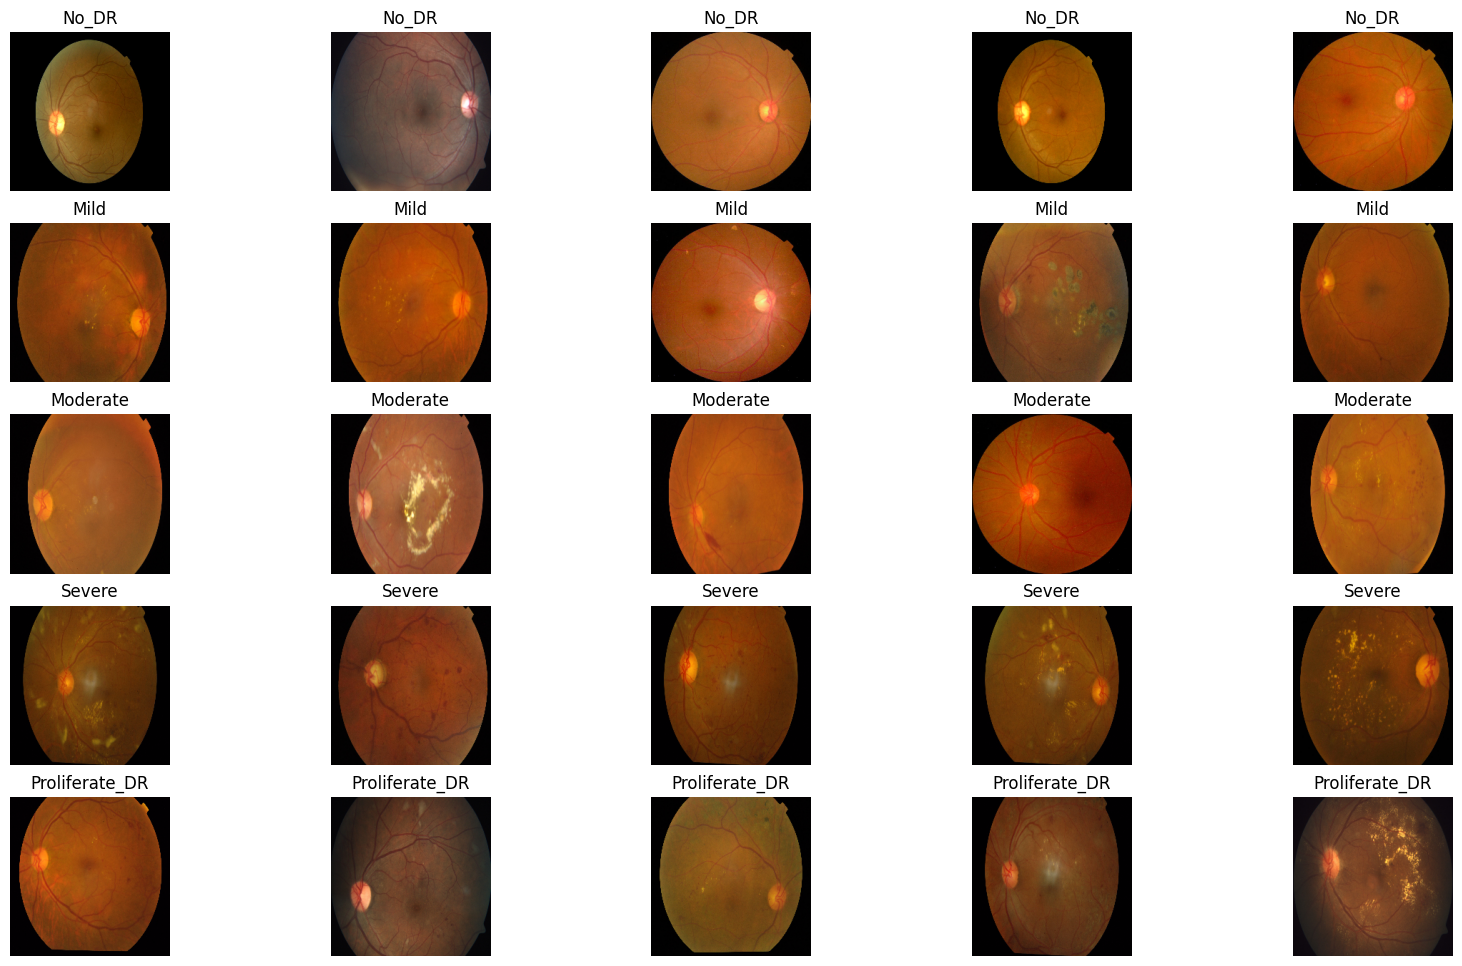

In [43]:
plt.figure(figsize=(20, 12))
images_per_label = 5
for i, label in enumerate(labels):
    folder_path = os.path.join(data_dir, label)
    for j in range(images_per_label):
        img_file = os.listdir(folder_path)[j]
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)                 # BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
        plt.subplot(len(labels), images_per_label, i*images_per_label + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
plt.show()

In [44]:
all_labels = []
for idx, cls in enumerate(labels):
    all_labels.extend([idx]*class_counts[cls])
all_labels = np.array(all_labels)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [46]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [47]:

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 2931 images belonging to 5 classes.


In [48]:
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 731 images belonging to 5 classes.


In [49]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights="/kaggle/input/resnet50-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
    include_top=False,
    input_shape=(224,224,3)
)


In [50]:

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(len(labels), activation='softmax')  
])

In [51]:

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 24,586,245 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [53]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    class_weight=class_weights

)

Epoch 1/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 1114s 6s/step - accuracy: 0.7049 - loss: 1.2325 - val_accuracy: 0.4938 - val_loss: 1.7117
Epoch 2/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 1121s 6s/step - accuracy: 0.7499 - loss: 1.1326 - val_accuracy: 0.4938 - val_loss: 1.4776
Epoch 3/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 1099s 6s/step - accuracy: 0.7533 - loss: 0.9747 - val_accuracy: 0.5773 - val_loss: 1.2417
